In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time

import pennylane.numpy as np
import pennylane as qml

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, array_to_latex

import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 4)

### Graph class

In [2]:
class Node: # to represent vertices
    def __init__(self, coords):
        self.coords = coords
        self.number = None
        self.x = coords[0]
        self.y = coords[1]
        
    def distance(self, other): # Euclidian distance from one node to another
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

class Graph: # to represent graphs
    def __init__(self, nodes, dist=1):
        self.nodes = nodes
        self.edges = [] # tuples of connected vertices (nodes)
        self.edges_numbered = [] # tuples of numbers connected vertices (nodes)
        self.num_nodes = len(nodes)
        for i, node in enumerate(nodes): # assigning a number to every node
            node.number = i
        for i, node1 in enumerate(nodes):
            for j, node2 in enumerate(nodes[:i]):
                if node1.distance(node2) <= dist: # if nodes lay within dist, they are connected by an edge
                    self.edges.append((node1, node2))
                    self.edges_numbered.append((node1.number, node2.number))
                    
    def adj_matrix(self): # calculates adjacency matrix
        matrix = np.zeros((self.num_nodes, self.num_nodes))
        for i, node1 in enumerate(self.nodes):
            for j, node2 in enumerate(self.nodes[:i]):
                if (node1, node2) in self.edges or (node2, node1) in self.edges:
                    matrix[i][j] = 1
                    matrix[j][i] = 1
        return matrix
                    
    def draw(self, axis='off'): # draws the graph in XY - plane
        figure, axes = plt.subplots()
        for pair in self.edges:
            axes.plot([pair[0].x, pair[1].x], [pair[0].y, pair[1].y], 'black', linestyle="--")
        for node in self.nodes:
            axes.add_patch(Circle([node.x, node.y], 0.05, color='blue'))
            axes.text(node.x-0.015, node.y-0.015, str(node.number), color='white')
        axes.axis(axis)

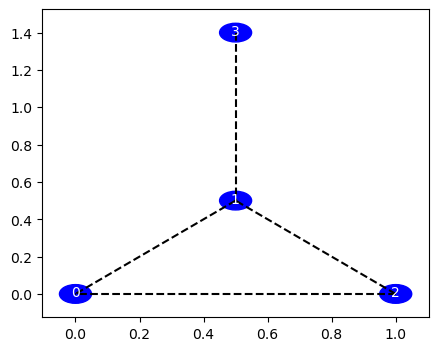

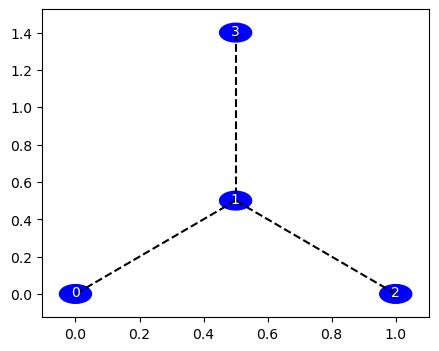

In [3]:
n0 = Node((0, 0))
n1 = Node((0.5, 0.5))
n2 = Node((1, 0))
n3 = Node((0.5, 1.4))

graph1 = Graph([n0, n1, n2, n3], dist=1)
graph2 = Graph([n0, n1, n2, n3], dist=0.9)
graph1.draw(axis='on')
graph2.draw(axis='on')

In [4]:
AM1 = graph1.adj_matrix()
array_to_latex(AM1)

<IPython.core.display.Latex object>

In [5]:
AM2 = graph2.adj_matrix()
array_to_latex(AM2)

<IPython.core.display.Latex object>

### Custom Hamiltonian

In [6]:
def matrix_from_string(string): # calculates a matrix representation of string from the {I, P} alphabet
    matrices = {
    'I' : np.array([[1,0], [0,1]], dtype='complex128'), # identity
    'P' : np.array([[0,0], [0,1]], dtype='complex128')  # projector |1><1|
    }
    matrix = matrices[string[0]]
    length = len(string)
    for i in range(1, length):
        matrix = tensor(matrix, matrices[string[i]])
    return matrix

def tensor(A, B): # tensor product of matrices A and B    
    blocks = []
    vector_A = A.reshape(A.shape[0]*A.shape[1], 1)
    for i in range(A.shape[0]*A.shape[1]):
        blocks.append(vector_A[i]*B)
    blocks1 = []
    for i in range(A.shape[1]):
        row = np.concatenate(([blocks[j] for j in range(i*A.shape[0], i*A.shape[0]+A.shape[1])]), axis=1)
        blocks1.append(row)
    result = np.concatenate((blocks1), axis=0)
    return result

In [63]:
def get_hamiltonian(graph): # generates MIS Hamiltonian for a given graph
    H = np.zeros((2**graph.num_nodes, 2**graph.num_nodes), dtype='complex128')
    AM = graph.adj_matrix()
    for i, node1 in enumerate(graph.nodes):
        string = [ch for ch in 'I'*graph.num_nodes]
        string[i] = 'P'
        string = ''.join(string)
        op = (-1)*matrix_from_string(string)
        H += op                                        # |1><1|_j element of the Hamiltonian
        for j, node2 in enumerate(graph.nodes[:i]):
            if AM[i][j] == 1:
                string1 = [ch for ch in 'I'*graph.num_nodes]
                string1[i] = 'P'
                string1[j] = 'P'
                string1 = ''.join(string1)
                op1 = 747.78*matrix_from_string(string1)
                H += op1                               # interaction element of the Hamiltonian
    return H

In [64]:
obs1 = qml.Hermitian(get_hamiltonian(graph1), wires=[0, 1, 2, 3])
hamiltonian1 = qml.Hamiltonian((1, ), (obs1, )) # H1 to Pennylane Hamiltonian
print(hamiltonian1)

  (1) [Hermitian0,1,2,3]


In [65]:
obs2 = qml.Hermitian(get_hamiltonian(graph2), wires=[0, 1, 2, 3])
hamiltonian2 = qml.Hamiltonian((1, ), (obs2, )) # H2 to Pennylane Hamiltonian
print(hamiltonian2)

  (1) [Hermitian0,1,2,3]


### Define the Model

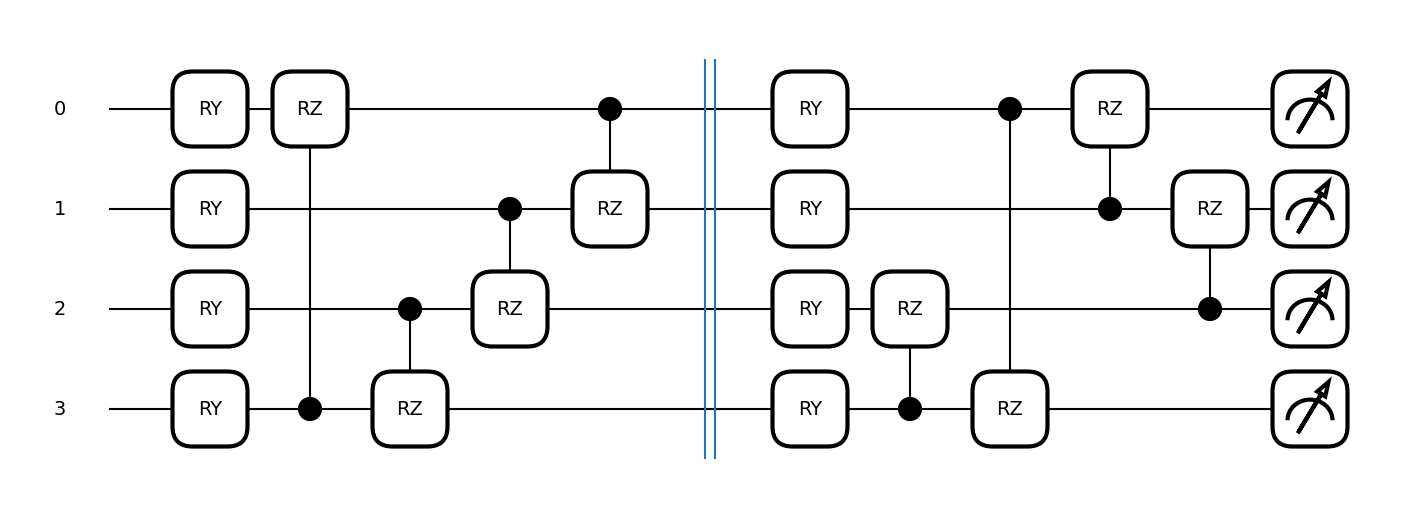

In [66]:
dev = qml.device("lightning.qubit", wires=4) # lightning for faster work

@qml.qnode(dev, interface="autograd")
def ansatz(weights, hamiltonian, wires): # VQE ansatz with 16 parameters
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.RY(weights[2], wires=wires[2])
    qml.RY(weights[3], wires=wires[3])
    
    qml.CRZ(weights[4], wires=[wires[3], wires[0]])
    qml.CRZ(weights[5], wires=[wires[2], wires[3]])
    qml.CRZ(weights[6], wires=[wires[1], wires[2]])
    qml.CRZ(weights[7], wires=[wires[0], wires[1]])
    qml.Barrier()
    qml.RY(weights[8], wires=wires[0])
    qml.RY(weights[9], wires=wires[1])
    qml.RY(weights[10], wires=wires[2])
    qml.RY(weights[11], wires=wires[3])

    qml.CRZ(weights[13], wires=[wires[3], wires[2]])
    qml.CRZ(weights[12], wires=[wires[0], wires[3]])
    qml.CRZ(weights[14], wires=[wires[1], wires[0]])
    qml.CRZ(weights[15], wires=[wires[2], wires[1]])
    
    return qml.expval(hamiltonian)

np.random.seed(42)
fig, ax = qml.draw_mpl(ansatz)( np.random.random(size=(16,1)), hamiltonian1, wires=[0,1,2,3] )

In [67]:
def expvalue1(weights): # cost function = < H >
    return ansatz(weights, hamiltonian1, wires=[0,1,2,3])

def expvalue2(weights): # cost function = < H >
    return ansatz(weights, hamiltonian2, wires=[0,1,2,3])

### Optimization loop

In [68]:
np.random.seed(1)
weights1 = np.random.random(size=[16, 1], requires_grad=True) # weights to optimize for the first graph
weights2 = weights1 # weights to optimize for the second graph
optimizer = qml.GradientDescentOptimizer(stepsize=0.002)
start_time = time.time()
num_steps = 3000
for k in range(num_steps+1):
    step1 = optimizer.step_and_cost(expvalue1, weights1) # gradient descent step for graph 1
    step2 = optimizer.step_and_cost(expvalue2, weights2) # gradient descent step for graph 2
    if k % 1000 == 0:
        print(f"Step {k}, cost1: {step1[1]};   cost2: {step2[1]}")
    weights1 = step1[0]
    weights2 = step2[0]
end_time = time.time()
print(f'{end_time-start_time}s')

Step 0, cost1: 113.70369848774355;   cost2: 108.66788385092578
Step 1000, cost1: -0.32523816212001905;   cost2: -0.8485750759602854
Step 2000, cost1: -1.3914370694092333;   cost2: -1.6769365196573438
Step 3000, cost1: -1.2409941252904586;   cost2: -0.7853262254147023
1971.047357082367s


In [69]:
weights1, weights2

(tensor([[ 8.23176964e-01],
         [ 9.07946536e-08],
         [-1.93602834e-01],
         [ 8.47917587e-01],
         [ 1.73853936e-01],
         [ 3.78262369e-04],
         [ 1.15955175e-01],
         [ 4.64682535e-01],
         [ 7.69498654e-01],
         [-9.06740595e-08],
         [ 1.93602832e-01],
         [ 1.22104303e+00],
         [ 2.04452250e-01],
         [ 8.78117436e-01],
         [ 2.73875932e-02],
         [ 6.70467510e-01]], requires_grad=True),
 tensor([[ 0.97947622],
         [-0.04040844],
         [ 0.32959596],
         [ 0.89676468],
         [ 0.16288606],
         [ 0.08548306],
         [ 0.16382254],
         [ 0.44481986],
         [ 0.92505862],
         [-0.04047441],
         [ 0.73225558],
         [ 1.26987144],
         [ 0.20445225],
         [ 0.87811744],
         [ 0.02738759],
         [ 0.67046751]], requires_grad=True))

### Qiskit to simulate the resultant state vector

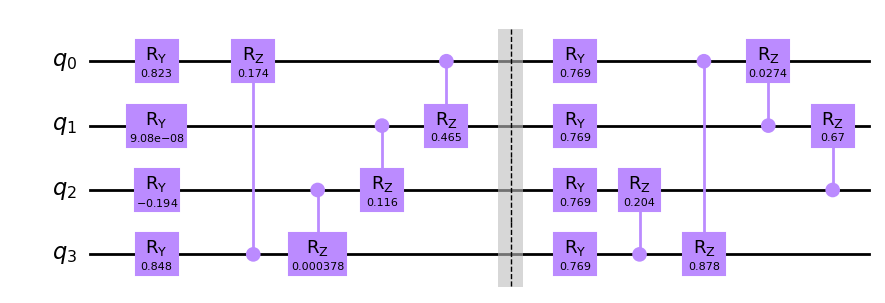

In [70]:
def circuit(weights):
    qc = QuantumCircuit(4)
    for i in range(4):
        qc.ry(weights.item(i), i)

    qc.crz(weights.item(4), 3, 0)
    qc.crz(weights.item(5), 2, 3) 
    qc.crz(weights.item(6), 1, 2) 
    qc.crz(weights.item(7), 0, 1) 
    qc.barrier()
    for i in range(4):
        qc.ry(weights.item(8), i)
    qc.crz(weights.item(12), 3, 2)
    qc.crz(weights.item(13), 0, 3) 
    qc.crz(weights.item(14), 1, 0) 
    qc.crz(weights.item(15), 2, 1)
    return qc

qc1 = circuit(weights1)
qc2 = circuit(weights2)
qc1.draw('mpl')

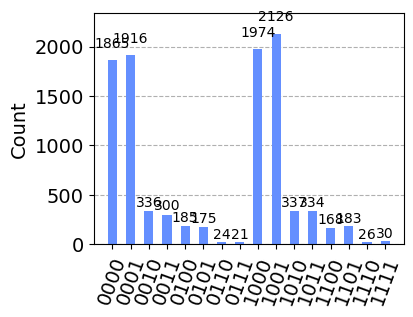

In [71]:
sv1 = Statevector.from_label('0'*graph1.num_nodes) # initialize to the ground state
sv1 = sv1.evolve(qc1) # evolve through the circuit with learned angles
counts1 = sv1.sample_counts(10000)
plot_histogram(counts1, figsize=(4,3))

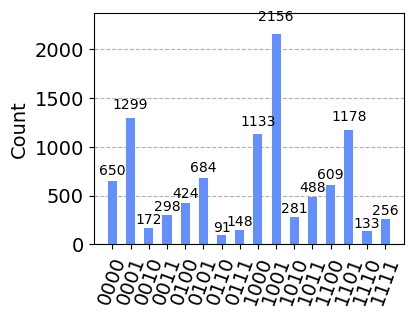

In [72]:
sv2 = Statevector.from_label('0'*graph2.num_nodes) # initialize to the ground state
sv2 = sv2.evolve(qc2) # evolve through the circuit with learned angles
counts2 = sv2.sample_counts(10000)
plot_histogram(counts2, figsize=(4,3))